In [18]:
# standard binary classification modelling
import pandas as pd
import numpy as np

filename = 'train.csv'
df_input = pd.read_csv(filename, sep=',')


In [19]:
# here we build the config of the file
from sklearn.cross_validation import train_test_split

identifier = ['PassengerId'] # identifier such as customer id
target = ['Survived'] # target field
exclude = ['Name', 'Ticket','Cabin'] # fields to exclude 
categorical = ['Sex','Embarked'] # these categorical fields get set to flag

# split sample into test and training set
# note that this split is not deterministic
df_train, df_test = train_test_split(df_input, test_size = 0.3)


In [20]:
# This tile fills in missing values
meanAge = df_train['Age'].mean()
df_train['Age'].fillna(meanAge, inplace=True)
df_test['Age'].fillna(meanAge, inplace=True)

/Users/roberthickling/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [21]:
# turns categorical variables into numerical (set to flag)
for i in range(0, len(categorical)):
    dummy_cat_train = pd.get_dummies(df_train[categorical[i]], prefix=categorical[i])
    dummy_cat_test = pd.get_dummies(df_test[categorical[i]], prefix=categorical[i])
    df_train = df_train.join(dummy_cat_train)
    df_test= df_test.join(dummy_cat_test)

df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C,0.0,1.0,1.0,0.0,0.0
662,663,0,1,"Colley, Mr. Edward Pomeroy",male,47.0,0,0,5727,25.5875,E58,S,0.0,1.0,0.0,0.0,1.0
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S,0.0,1.0,0.0,0.0,1.0
554,555,1,3,"Ohman, Miss. Velin",female,22.0,0,0,347085,7.7750,NaN,S,1.0,0.0,0.0,0.0,1.0
208,209,1,3,"Carr, Miss. Helen ""Ellen""",female,16.0,0,0,367231,7.7500,NaN,Q,1.0,0.0,0.0,1.0,0.0


In [22]:
def arrayify_data_and_target(data, label, exclude):
    """
    :param data: pandas DataFrame to split in to data and target
    :param label: name of the column to be used as dependent variable
    :param exclude: list of columns to exclude
    :return: (data, target, features)
    """
    dependent = data[label]
    independent = data.drop(exclude, axis=1)
    return np.array(independent), np.array(dependent), independent.columns.values

In [23]:
# remove all the fields not required
to_drop = exclude + target + categorical + identifier
X_train, Y_train, features_train = arrayify_data_and_target(df_train, target, to_drop)
X_test, Y_test, features_test = arrayify_data_and_target(df_test, target, to_drop)

In [24]:
# build the classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#clf = LogisticRegression(C=1, verbose=5, max_iter=300)
LR_balanced = LogisticRegression(C=1, class_weight='balanced', max_iter=300)
ada = AdaBoostClassifier(n_estimators=200)
RF = RandomForestClassifier(n_estimators=200, class_weight='balanced', max_leaf_nodes=300, max_features='auto')
#clf = SVC(probability=True, verbose=5, class_weight='balanced')

In [25]:
# fit the model(s) then score the test set
LR_balanced_model = LR_balanced.fit(X_train, Y_train.ravel())
ada_model = ada.fit(X_train, Y_train.ravel())
RF_model = RF.fit(X_train, Y_train.ravel())

Y_scores_LRb = LR_balanced_model.predict_proba(X_test)[:, 1]
Y_scores_ada = ada_model.predict_proba(X_test)[:, 1]
Y_scores_RF = RF_model.predict_proba(X_test)[:, 1]


In [26]:
# create fpr and tpr for the model outputs
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

fpr_lrb, tpr_lrb, thresholds_lrb = roc_curve(Y_test, Y_scores_LRb)
fpr_ada, tpr_ada, thresholds_ada = roc_curve(Y_test, Y_scores_ada)
fpr_RF, tpr_RF, thresholds_RF = roc_curve(Y_test, Y_scores_RF)

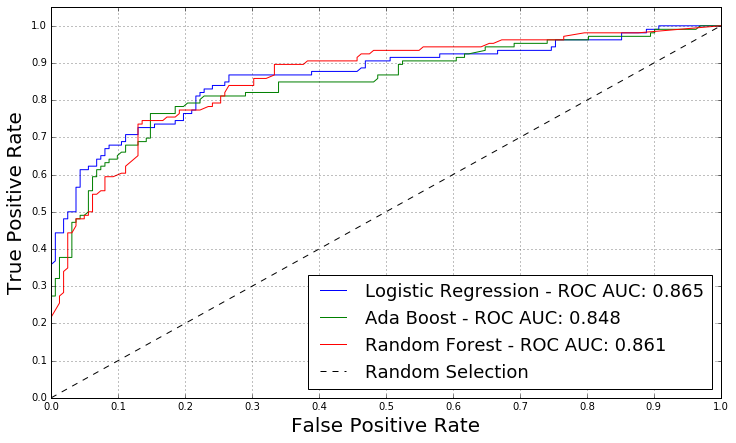

In [28]:
# Standard sklearn ROC curve
#roc_auc=round(scores['AUC score'],3)
%matplotlib inline
import matplotlib.pyplot as plt
roc_auc_lrb = auc(fpr_lrb, tpr_lrb)
roc_auc_ada = auc(fpr_ada, tpr_ada)
roc_auc_RF = auc(fpr_RF, tpr_RF)
plt.figure(figsize=(12,7))
plt.plot(fpr_lrb, tpr_lrb, label='Logistic Regression - ROC AUC: '+str(round(roc_auc_lrb,3)))
plt.plot(fpr_ada, tpr_ada, label='Ada Boost - ROC AUC: '+str(round(roc_auc_ada,3)))
plt.plot(fpr_RF, tpr_RF, label='Random Forest - ROC AUC: '+str(round(roc_auc_RF,3)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Selection')
plt.grid()
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend(loc="lower right", fontsize=18)
#plt.savefig("ROC_Curve_latency3_devsample.pdf")
plt.show()
plt.close()

In [32]:
importances = RF_model.feature_importances_
idxs = np.argsort(importances)[::-1]
for i in range(len(idxs)):
    #print >> f,("feature: {0} importance: {1}".format(features[idxs[i]], importances[idxs[i]]))
    #f.write("feature: {0} importance: {1}".format(features[idxs[i]], importances[idxs[i]])+'\n')
    print('Feature: '+str(features_train[idxs[i]]), 'Importance: '+str(importances[idxs[i]]))

Feature: Fare Importance: 0.269499312198
Feature: Age Importance: 0.262302730773
Feature: Sex_female Importance: 0.157186390654
Feature: Sex_male Importance: 0.10640188747
Feature: Pclass Importance: 0.0731416267936
Feature: SibSp Importance: 0.0579097008213
Feature: Parch Importance: 0.0326256083319
Feature: Embarked_S Importance: 0.0201891355736
Feature: Embarked_C Importance: 0.0130304985628
Feature: Embarked_Q Importance: 0.00771310882237
